<a href="https://colab.research.google.com/github/JoseArizpe01/Assignemnt1---ELEE6399/blob/main/Ch_5_7_House_Prices_Finalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install d2l==1.0.0a1.post0

In [ ]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
#KEEP/NEEDED

In [ ]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [ ]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding.
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [ ]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [ ]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [ ]:
#MLP Implementation for the Model 
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        #For 2 Layer
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))

        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))


In [ ]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
   # print(X.shape)
    X = X.reshape((-1, self.num_inputs))

    #FOR 2 LAYER
    H = relu(torch.matmul(X, self.W1) + self.b1) 
    return torch.matmul(H, self.W2) + self.b2
 

In [ ]:
@d2l.add_to_class(MLPScratch)  #@save
def loss(self, y_hat, y):
     l = (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
     return l.mean()

In [ ]:
#MLP Implementation for the Model 
class MLPScratch_4Layers(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, num_hiddens2, num_hiddens3, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        #For 4 Layer
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))

        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_hiddens2) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_hiddens2))

        self.W3 = nn.Parameter(torch.randn(num_hiddens2, num_hiddens3) * sigma)
        self.b3 = nn.Parameter(torch.zeros(num_hiddens3))

        self.W4 = nn.Parameter(torch.randn(num_hiddens3, num_outputs) * sigma)
        self.b4 = nn.Parameter(torch.zeros(num_outputs))

In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [ ]:
#Dropout Function
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)


In [ ]:
def l2_penalty(w):
    return (w ** 2).sum() / 2


In [ ]:
def k_fold(trainer,model, data, k):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

LINEAR REGRESSION --------------------------------------------------------------

average validation log mse = 0.02797205734997988


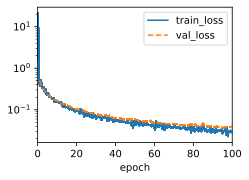

In [ ]:
#Model = Linear Regression  
data = KaggleHouse(batch_size=64)
data.preprocess() # Standardize and one_hot encode data
data.train.shape 

trainer = d2l.Trainer(max_epochs=100)
model = d2l.LinearRegression(lr = 0.01)
models = k_fold(trainer, model, data, k=5)

MULTIPLE LAYER PERCEPTON 2 LAYERS---------------------------------------------- 

average validation log mse = 0.010870353514328598


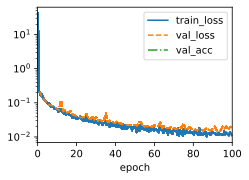

In [ ]:
#Data and processing 
data = KaggleHouse(batch_size=64)
data.preprocess() # Standardize and one_hot encode data
data.train.shape 

#Trainer
trainer = d2l.Trainer(max_epochs=100)

#-------------------------------------------------

#MODEL FOR 2 LAYERS
model = MLPScratch(num_inputs=331, num_outputs=1, num_hiddens= 250, lr=0.01)

models = k_fold(trainer, model ,data, k=5)

MULTIPLE LAYER PERCEPTON 4 LAYERS ----------------------------------------------

In [ ]:
@d2l.add_to_class(MLPScratch_4Layers)
def forward(self, X):
   # print(X.shape)
    X = X.reshape((-1, self.num_inputs))

#----------------------------------------
     
    #FOR 4 LAYERS 
    H = relu(torch.matmul(X, self.W1) + self.b1) 
    H2 = relu(torch.matmul(H, self.W2) + self.b2)
    H3 = relu(torch.matmul(H2, self.W3) + self.b3)
    return torch.matmul(H3, self.W4) + self.b4
 

In [ ]:
@d2l.add_to_class(MLPScratch_4Layers)  #@save
def loss(self, y_hat, y):
     l = (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
     return l.mean()

average validation log mse = 0.006670418074354529


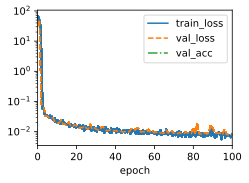

In [ ]:
#Data and processing 
data = KaggleHouse(batch_size=64)
data.preprocess() # Standardize and one_hot encode data
data.train.shape 

#Trainer
trainer = d2l.Trainer(max_epochs=100)

#--------------------------------------------------

#MODEL FOR 4 LAYERS
model = MLPScratch_4Layers(num_inputs=331, num_outputs=1, num_hiddens=250, num_hiddens2 = 250, num_hiddens3 = 250, lr=0.01)

#--------------------------------------------------

models = k_fold(trainer, model ,data, k=5)

WEIGHT DECAY -------------------------------------------------------------------

In [ ]:

#@d2l.add_to_class(MLPScratch)
class WeightDecayScratch(MLPScratch_4Layers):
    
    def __init__(self, num_inputs, num_outputs, num_hiddens, num_hiddens2, num_hiddens3, lr, lambd):
        super().__init__(num_inputs, num_outputs, num_hiddens, num_hiddens2, num_hiddens3, lr)
        self.save_hyperparameters()
       
    def loss(self, y_hat, y):
        l = ((y_hat - y.reshape(y_hat.shape)) ** 2 / 2) + self.lambd * (l2_penalty(self.W1)   + l2_penalty(self.W2) + l2_penalty(self.W3) + l2_penalty(self.W4) ) 
        return l.mean()
    

average validation log mse = 0.008283863067626953


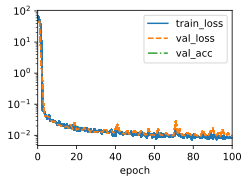

In [ ]:
#Data and processing 
data = KaggleHouse(batch_size=64)
data.preprocess() # Standardize and one_hot encode data
data.train.shape 

#Trainer
trainer = d2l.Trainer(max_epochs=100)

#------------------------------------------
#MODEL FOR WEIGHT DECAY

model = WeightDecayScratch(num_inputs=331, num_outputs = 1,num_hiddens = 250, num_hiddens2 = 250, num_hiddens3 = 250, lr=0.01, lambd = .0001)
models = k_fold(trainer, model ,data, k=5)

DROPOUT ------------------------------------------------------------------------

In [ ]:
@d2l.add_to_class(MLPScratch_4Layers)
def forward(self, X):
   # print(X.shape)
    X = X.reshape((-1, self.num_inputs))

#----------------------------------------
   
    #FOR 4 LAYERS
    H = relu(torch.matmul(X, self.W1) + self.b1) 

    H2 = relu(torch.matmul(H, self.W2) + self.b2)
    if self.training:
      H2 = dropout_layer(H2, .05)

    H3 = relu(torch.matmul(H2, self.W3) + self.b3)
    if self.training:
      H3 = dropout_layer(H3, .05)
      
    return torch.matmul(H3, self.W4) + self.b4

In [ ]:
@d2l.add_to_class(MLPScratch_4Layers)  #@save
def loss(self, y_hat, y):
     l = (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
     return l.mean()

average validation log mse = 0.008175381105393172


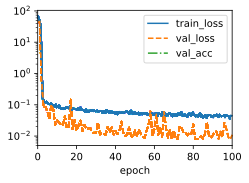

In [ ]:
#Data and processing 
data = KaggleHouse(batch_size=64)
data.preprocess() # Standardize and one_hot encode data
data.train.shape 

#Trainer
trainer = d2l.Trainer(max_epochs=100)

#--------------------------------------------------
model = MLPScratch_4Layers(num_inputs=331, num_outputs=1, num_hiddens=250, num_hiddens2 = 250, num_hiddens3 = 250, lr=0.01)

#MODEL FOR WEIGHT DECAY
#model = WeightDecayScratch(num_inputs=331, num_outputs = 1,num_hiddens = 200, num_hiddens2 = 10, num_hiddens3 = 20, lr=0.01, lambd = .01)

models = k_fold(trainer, model ,data, k=5)